In [2]:
import random, json, os

import numpy as np
import pandas as pd

from logic import Game

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Conv2D, Flatten, Dense, Concatenate, Input, BatchNormalization
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import Callback


import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib notebook

In [22]:
class Agent(Game):
    
    def __init__(self, model_number=None, learning_rate=0.001):

        super().__init__()
        if model_number == None:
            models = os.listdir('{}\models'.format(os.getcwd()))
            if len(models) > 0:
                model_number = len(models)
            else:
                model_number = 1
        os.mkdir('{}\models\{}'.format(os.getcwd(), str(model_number)))
        self.model_file = '{}\models\{}'.format(os.getcwd(), str(model_number))
        self.learning_rate = learning_rate
        self.input_dim = self.get_state().shape
        self.build_network()
        self.model.summary()
        

    def build_network(self):
        
        


    def get_action(self, state, invalid_moves=[], epsilon=1):

        if len(state.shape) == 3:
            state = np.expand_dims(state, 0)
        
        rand = np.random.rand()
        if rand <= epsilon:
            # Exploit
            pred = np.squeeze(self.model.predict(state))
            return np.argmax(pred)
            
        else:
            # Explore
            return(int(np.random.randint(0, high=4)))


    def fit(self, state=None, action=None, reward=None):

        m = self.replay.shape[0]
        
        if state == None and action == None and reward == None:
            state = np.array(self.replay.s.tolist())
            reward = self.replay.r.values.reshape(m, 1)
            action = to_categorical(self.replay.a.values)
            
        else:
            if state == None:
                raise "Must provide state, action and reward to train. If all are 'None', then replay will be used"
            if action == None:
                raise "Must provide state, action and reward to train. If all are 'None', then replay will be used"
            if reward == None:
                raise "Must provide state, action and reward to train. If all are 'None', then replay will be used"
        
        self.model.fit(state, reward, verbose=0)
        

    def run_episode(self, epsilon=1):

        self.reset()
        state_list = []
        action_list = []
        reward_list = []

        done = False
        while not done:
            state = self.get_state()
            action = self.get_action(state, epsilon=epsilon)
            done, tiles_made = self.step(action)
            new_state = self.get_state()

            state_list.append(state)
            action_list.append(action)
            reward_list.append(sum(tiles_made))

        return (self.score, self.highest_tile(), action_list, state_list, reward_list)


    def train(self, episodes, eval_interval=1000, eval_number=100):
        
        self.replay = pd.DataFrame({
            's': [],
            'a': [],
            'r': []
        })

        self.create_plots()

        for episode in range(episodes):

            score, tile, action, state, reward = self.run_episode(epsilon=self.epsilon)
            discounted_reward = self.compute_discounted_reward(reward)
            self.update_replay(state, action, discounted_reward)

            self.fit(state, action, discounted_reward)
            
            self.update_plots(tile, score)
            
            #if episode%eval_interval == 0 and episode != 0:
            #    self.evaluate_model(eval_number, episode)
                
    
    def compute_discounted_reward(self, reward):
        
        m = len(reward)
        tri = np.triu(np.ones((m,m)))
        discounted_reward = np.dot(tri, np.array(reward))
        return discounted_reward
                
                
    def evaluate_model(self, episodes, train_episodes):
        
        if 'eval' not in list(os.listdir(self.model_file)):
            eval_dir = self.model_file + '\eval'
            os.mkdir(eval_dir)
        
        eval_dic = {'tile': [], 'score': [], 'state': [], 'action': []}
        
        for i in range(train_episodes):
            score, tile, action, state, reward = self.run_episode()
            
            eval_dic['tile'].append(tile)
            eval_dic['score'].append(score)
            eval_dic['state'].append([s.tolist() for s in state])
            eval_dic['action'].append(action)

        file_name = self.model_file + '\eval\{}'.format(train_episodes)
        
        df = pd.DataFrame.from_dict(eval_dic)
        df.to_csv(file_name)
        
            
    def update_replay(self, state, action, reward):
        
        new_data = pd.DataFrame({
                's': [state.tolist() for state in state],
                'a': action,
                'r': reward
            })
        
        self.replay = pd.concat([new_data, self.replay], ignore_index=True)
        
        m = self.replay.shape[0]
        if m > 10**4:
            index = range(10**4, m)
            self.replay.drop(index=index, inplace=True)
        
        
    def create_plots(self):
        self.score_list = []
        self.score_figure = plt.figure()
        self.score_ax = self.score_figure.add_subplot(111)
        self.score_figure.show()
        self.score_figure.canvas.draw()
        
        self.tile_list = []
        self.tile_dic = {}
        self.tile_figure = plt.figure()
        self.tile_ax = self.tile_figure.add_subplot(111)
        self.tile_ax.legend()
        self.tile_figure.show()
        self.tile_figure.canvas.draw()
        
        self.weights_dic = {}
        self.weights_dic[0] = []
        self.weights_dic[1] = []
        self.weights_dic[-1] = []
        self.weights_figure = plt.figure()
        self.weights_ax = self.weights_figure.add_subplot(111)
        self.weights_figure.show()
        self.weights_figure.canvas.draw()
        
        self.biases_dic = {}
        self.biases_dic[0] = []
        self.biases_dic[1] = []
        self.biases_dic[-1] = []
        self.biases_figure = plt.figure()
        self.biases_ax = self.biases_figure.add_subplot(111)
        self.biases_figure.show()
        self.biases_figure.canvas.draw()
        
    
    def update_plots(self, tile, score):
        
        self.score_list.append(score)
        self.score_ax.clear()
        self.score_ax.plot(range(len(self.score_list)), self.score_list)
        self.score_figure.canvas.draw()
        
        self.tile_list.append(tile)
        for key in self.tile_dic.keys():
            if key != tile:
                self.tile_dic[key].append(self.tile_dic[key][-1]*.99)
        if tile in self.tile_dic.keys():
            self.tile_dic[tile].append(self.tile_dic[tile][-1]*.99 + 0.01)
        else:
            self.tile_dic[tile] = [0]*len(self.tile_list)
            self.tile_dic[tile][-1] = 0.01
        self.tile_ax.clear()
        for key in self.tile_dic.keys():
            self.tile_ax.plot(range(len(self.tile_list)), self.tile_dic[key], label=str(key))
        self.tile_ax.legend(loc='upper left')
        self.tile_figure.canvas.draw()
        
        tot_weights = None
        tot_biases = None
        for layer in [layer.get_weights() for layer in agent.model.layers]:
            if len(layer) > 0:
                weights, biases = layer
                if tot_weights is None:
                    tot_weights = weights.flatten()
                else:
                    tot_weights = np.concatenate((tot_weights, weights.flatten()))

                if tot_biases is None:
                    tot_biases = biases.flatten()
                else:
                    tot_biases = np.concatenate((tot_biases, biases.flatten()))
        
        weights_mean = np.mean(tot_weights)
        weights_std = np.std(tot_weights)
        biases_mean = np.mean(tot_biases)
        biases_std = np.std(tot_biases)
        
        self.weights_dic[0].append(weights_mean)
        self.weights_dic[1].append(weights_mean + weights_std)
        self.weights_dic[-1].append(weights_mean - weights_std)
        self.biases_dic[0].append(biases_mean)
        self.biases_dic[1].append(biases_mean + biases_std)
        self.biases_dic[-1].append(biases_mean - biases_std)
        
        self.weights_ax.clear()
        self.weights_ax.plot(range(len(self.weights_dic[0])), self.weights_dic[0])
        self.weights_ax.plot(range(len(self.weights_dic[1])), self.weights_dic[1])
        self.weights_ax.plot(range(len(self.weights_dic[-1])), self.weights_dic[-1])
        self.weights_figure.canvas.draw()
        
        self.biases_ax.clear()
        self.biases_ax.plot(range(len(self.biases_dic[0])), self.biases_dic[0])
        self.biases_ax.plot(range(len(self.biases_dic[1])), self.biases_dic[1])
        self.biases_ax.plot(range(len(self.biases_dic[-1])), self.biases_dic[-1])
        self.biases_figure.canvas.draw()

In [8]:
r = np.array([1,2,3])
t = np.triu(np.ones((3,3)))
p = np.dot(t,r)
print(p)

[6. 5. 3.]


In [23]:
agent = Agent(learning_rate=0.001)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 4, 4, 1)      0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 3, 3, 32)     160         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 1, 4, 32)     160         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 4, 1, 32)     160         input_9[0][0]                    
____________________________________________________________________________________________

<IPython.core.display.Javascript object>


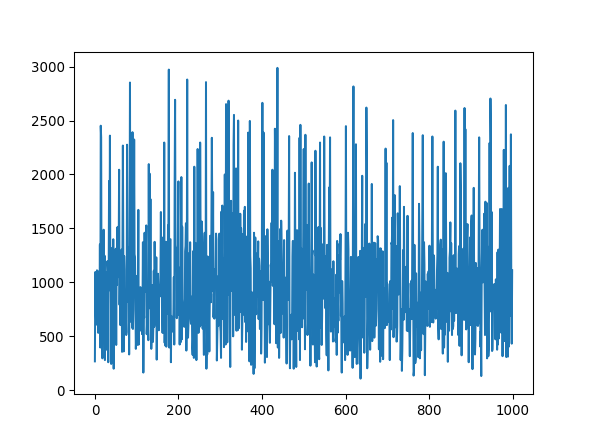

<IPython.core.display.Javascript object>


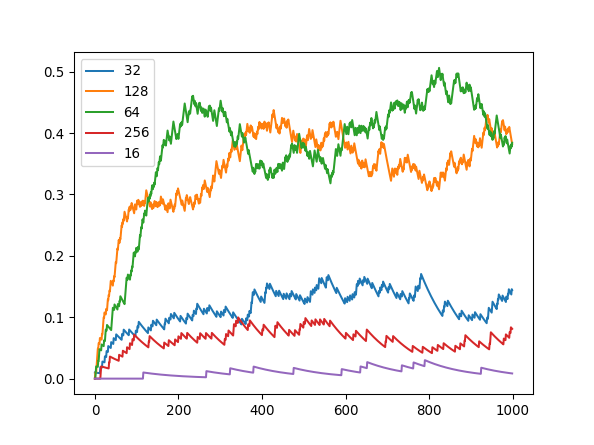

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


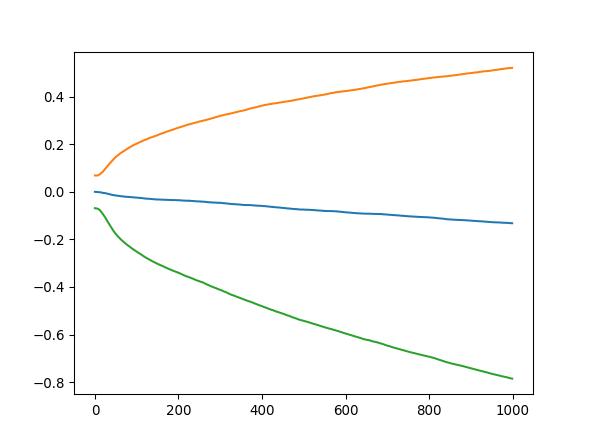

<IPython.core.display.Javascript object>


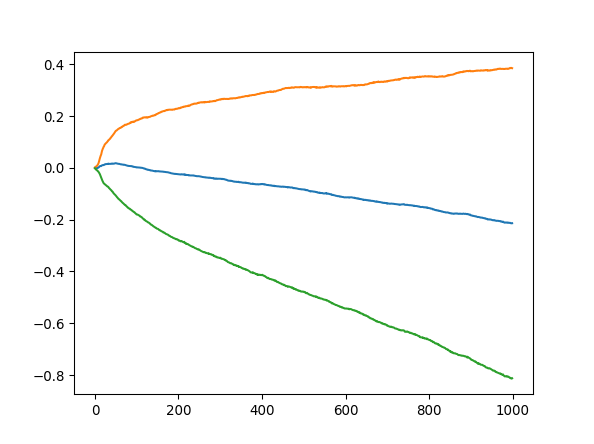

In [24]:
agent.train(1000, eval_interval=1000, eval_number=100)

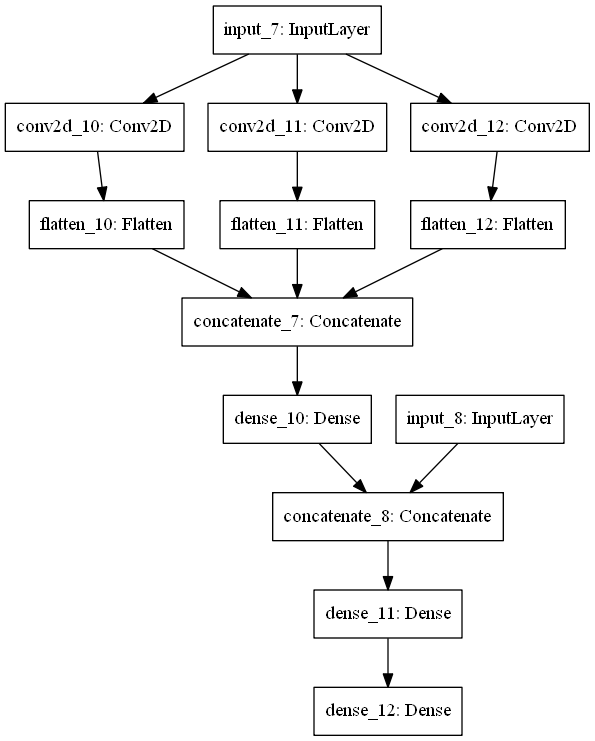

In [20]:
plot_model(agent.model)

In [21]:
agent.replay

,s,a,r
0,"[[[0.0], [0.0], [0.0], [0.0]], [[1.0], [2.0], ...",0.0,0.0
1,"[[[0.0], [0.0], [0.0], [2.0]], [[1.0], [2.0], ...",0.0,0.0
2,"[[[2.0], [0.0], [0.0], [0.0]], [[1.0], [2.0], ...",0.0,0.0
3,"[[[2.0], [0.0], [0.0], [0.0]], [[1.0], [2.0], ...",0.0,0.0
4,"[[[2.0], [0.0], [0.0], [0.0]], [[1.0], [2.0], ...",0.0,0.0
...,...,...,...
129,"[[[4.0], [1.0], [2.0], [1.0]], [[1.0], [3.0], ...",0.0,0.0
130,"[[[4.0], [1.0], [2.0], [1.0]], [[1.0], [3.0], ...",0.0,0.0
131,"[[[4.0], [1.0], [2.0], [1.0]], [[1.0], [3.0], ...",2.0,12.0
132,"[[[4.0], [1.0], [3.0], [2.0]], [[1.0], [3.0], ...",0.0,0.0
